In [1]:
import json
import os
import numpy as np
import scipy.ndimage
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random

# Define base directory for your data
base_dir = 'k:/HSI/'

# Load the JSON files
def load_data(file_path):
    with open(file_path) as f:
        return json.load(f)

data_train = load_data('k:/HSI/train_only_labeled_v2.json')

# Map ripeness states to numerical labels
ripeness_map = {
    "unripe": 0,
    "perfect": 1,
    "overripe": 2
}

# Function to read the binary data
def read_bin_file(bin_file_path, hdr_file_path):
    try:
        with open(hdr_file_path, 'r') as f:
            for line in f:
                if "samples" in line:
                    width = int(line.split('=')[-1].strip())
                elif "lines" in line:
                    height = int(line.split('=')[-1].strip())
                elif "bands" in line:
                    bands = int(line.split('=')[-1].strip())

        bin_path = os.path.join(base_dir, bin_file_path)
        with open(bin_path, 'rb') as f:
            data = np.fromfile(f, dtype=np.float32)
        data = data.reshape((height, width, bands))
        
        return data
    
    except FileNotFoundError as e:
        print(f"File not found: {e.filename}")
        return None

# Function to resize hyperspectral data to a consistent shape
def resize_hyperspectral_data(data, target_shape=(64, 64, 224)):
    current_shape = data.shape
    if current_shape != target_shape:
        zoom_factors = [target_shape[i] / current_shape[i] for i in range(3)]
        resized_data = scipy.ndimage.zoom(data, zoom_factors, order=1)
        return resized_data
    return data

# Function to extract features and labels
def extract_features_and_labels(data, annotations_dict, X_list, y_ripeness_list):
    for record in data['records']:
        if record['fruit'].lower() == "kaki":
            bin_file = record['files']['data_file']
            hdr_file = record['files']['header_file']
            record_id = record['id']
            
            # Load and resize hyperspectral data
            hyperspectral_data = read_bin_file(bin_file, hdr_file)
            if hyperspectral_data is None:
                continue
            
            hyperspectral_data = resize_hyperspectral_data(hyperspectral_data)
            X_list.append(hyperspectral_data)

            # Get ripeness annotation
            if record_id in annotations_dict:
                ripeness_state = annotations_dict[record_id]['ripeness_state']
                y_ripeness_list.append(ripeness_map[ripeness_state])
            else:
                print(f"Warning: No annotation found for record_id {record_id}")

# Prepare training data
annotations_dict_train = {annot['record_id']: annot for annot in data_train['annotations']}
X, y_ripeness = [], []
extract_features_and_labels(data_train, annotations_dict_train, X, y_ripeness)

# Convert to numpy arrays
X = np.array(X)
y_ripeness = np.array(y_ripeness)

# One-hot encode the ripeness labels
y_ripeness = to_categorical(y_ripeness, num_classes=3)

# Function to augment a single hyperspectral image by applying random transformations
def augment_image(data):
    if random.choice([True, False]):
        data = np.flip(data, axis=0)  # Flip vertically
    if random.choice([True, False]):
        data = np.flip(data, axis=1)  # Flip horizontally
    if random.choice([True, False]):
        data = scipy.ndimage.rotate(data, angle=random.randint(-20, 20), axes=(0, 1), reshape=False)
    if random.choice([True, False]):
        shift = random.uniform(-0.1, 0.1)
        data = scipy.ndimage.shift(data, shift=[shift, shift, 0], mode='nearest')
    
    return data

# Function to balance classes using augmentation
def balance_classes(X, y, target_count=84):
    X_balanced, y_balanced = [], []
    for class_label in range(3):  # For each class label
        class_indices = np.where(np.argmax(y, axis=1) == class_label)[0]
        current_count = len(class_indices)
        print("i am in")
        # Add original samples for the class
        for idx in class_indices:
            X_balanced.append(X[idx])
            y_balanced.append(y[idx])
        
        # Generate augmented samples if the current count is less than the target count
        if current_count < target_count:
            augment_needed = target_count - current_count
            for _ in range(augment_needed):
                original = X[random.choice(class_indices)]
                augmented = augment_image(original)
                X_balanced.append(augmented)
                y_balanced.append(to_categorical(class_label, num_classes=3))
    
    return np.array(X_balanced), np.array(y_balanced)

# Balance the classes
target_count = max(np.count_nonzero(y_ripeness == 1), 84)  # Setting target as the highest count among classes
X_balanced, y_balanced = balance_classes(X, y_ripeness, target_count=target_count)
print(y_balanced)
# Train-test split on the balanced dataset
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Print the shapes to verify
print("Shapes after balancing:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)


i am in
i am in
i am in
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
Shapes after balancing:
X_train: (268, 64, 64, 224)
y_train: (268, 3)
X_val: (68, 64, 64, 224)
y_val: (68, 3)


C:\Users\kpoff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 0.3250 - loss: 1.5841 - val_accuracy: 0.3824 - val_loss: 1.5082
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.5967 - loss: 0.9166 - val_accuracy: 0.3824 - val_loss: 1.4407
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.5840 - loss: 0.8954 - val_accuracy: 0.3824 - val_loss: 3.2406
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.6469 - loss: 0.8569 - val_accuracy: 0.3824 - val_loss: 2.8514
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.6650 - loss: 0.7457 - val_accuracy: 0.3824 - val_loss: 4.7377
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.7460 - loss: 0.5417 - val_accuracy: 0.5441 - val_loss: 1.3109
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.6759 - loss: 0.8505 - val_accuracy: 0.3824 - val_loss: 8.9870
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - accuracy: 0.7249 - loss: 0.5679 - val_accu

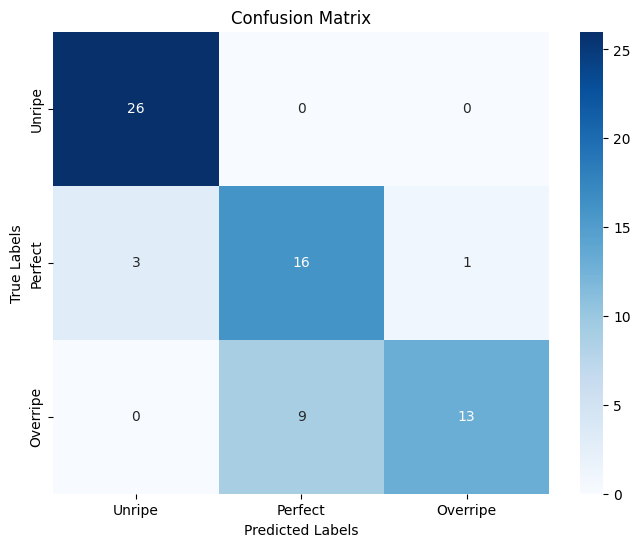

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the modified AlexNet model
def create_alexnet(input_shape=(64, 64, 224), num_classes=3):
    model = models.Sequential([
        # First Convolutional Layer
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
        
        # Second Convolutional Layer
        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
        
        # Third Convolutional Layer
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        
        # Fourth Convolutional Layer
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        
        # Fifth Convolutional Layer
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
        
        # Global Average Pooling to adapt to the feature map size
        layers.GlobalAveragePooling2D(),
        
        # Fully Connected Layers
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        
        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Instantiate and compile the model
model = create_alexnet(input_shape=(64, 64, 224), num_classes=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val))

# Generate predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_val.argmax(axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=["Unripe", "Perfect", "Overripe"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Unripe", "Perfect", "Overripe"], yticklabels=["Unripe", "Perfect", "Overripe"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
